In [25]:
from os import sys, path
sys.path.append(path.dirname(path.dirname(path.abspath('__file__'))))

import pprint

from sklearn import metrics
from sklearn import preprocessing

import h5py

from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.decomposition import PCA

import os
from sklearn.model_selection import cross_val_predict

from sklearn.naive_bayes import GaussianNB
import matplotlib
from functools import reduce

In [26]:
# https://stackoverflow.com/questions/38601026/easy-way-to-use-parallel-options-of-scikit-learn-functions-on-hpc/38814491#38814491

In [27]:
np.random.seed(0)

In [28]:
from sklearn.neighbors import KNeighborsClassifier

In [29]:
final = pd.read_csv('./final_trans.csv', index_col='Unnamed: 0')
final.head()

,home_team,away_team,EH,EA,result_final
0,2997,782,100.000000,100.000000,1.0
1,2073,2072,100.000000,100.000000,1.0
2,7022,6281,100.000000,100.000000,1.0
3,1328,2217,90.143872,109.856128,2.0
4,4397,3683,105.000000,95.000000,0.0


In [30]:
def filter_out_100(data):
    print('[Filter]')
    dataf = data[(data.EH!=100) & (data.EA!=100)].iloc[:]
    return dataf

def plot_data_labels(data, labels=['1','X','2'], npoints=1000):
    x = data.iloc[:npoints]['EH'].values
    y = data.iloc[:npoints]['EA'].values
    label = data.iloc[:npoints][result_key].values
    colors = ['green','blue','black']

    fig = plt.figure(figsize=(8,8))
    plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))
    plt.xlabel('EH')
    plt.ylabel('EA')
    cb = plt.colorbar()
    loc = np.arange(0,max(label),max(label)/float(len(colors)))
    cb.set_ticks(loc)
    cb.set_ticklabels(labels)
    return data

def run_pca(data):
    print('[PCA]')

    pca = PCA(n_components=2)

    # print(pca.explained_variance_ratio_)  

    # print(pca.singular_values_)  

    pca.fit(data.values[:,[2,3]])

    tx =  pca.transform(data.values[:,[2,3]]) 

    data.loc[:,['EH','EA']] = tx
    return data

def classify(data):
    print(data.head())
    print('[Classifier]')
    X = data.iloc[:][['home_team','away_team','EH','EA']]#.values
    # X = final.iloc[:][['EH','EA']]#.values
    y = data.iloc[:][result_key]#.values

    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75, test_size=0.25, random_state=42)

    # final.iloc[:50000].tail()

    clf = GaussianNB()
    clf = clf.fit(X_train, y_train)

    print('Accuracy: ',clf.score(X_test, y_test))
    # print(metrics.accuracy_score(clf.predict(X_test), y_test))
    # clf.export('tpot_mnist_pipeline.py')

    predictions = clf.predict(X_test)

    pprint.pprint(metrics.classification_report(predictions, y_test))

#     predicted = cross_val_predict(clf, X,y, cv=5)
    return data

def pipeline_func(data, fns):
    return reduce(lambda a,x: x(a), fns, data)

# MACHINE LEARNING SECTION

In [31]:
fd = run_pca(filter_out_100(final))

[Filter]
[PCA]


In [32]:
result_key = 'result_final'

In [33]:
X = fd.iloc[:][['home_team','away_team','EH','EA']]#.values
y = fd.iloc[:][result_key]#.values

## KNeighborsClassifier

In [34]:
from sklearn.neighbors import KNeighborsClassifier
weights = ['distance','uniform']

In [35]:
clf = KNeighborsClassifier(n_neighbors=5,weights=weights[0])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75, test_size=0.25, random_state=42)

In [37]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [38]:
y_pred = clf.predict(X_test)

X.shape

pprint.pprint(metrics.accuracy_score(y_pred, y_test))
pprint.pprint(metrics.classification_report(y_pred, y_test))

0.6406574437745478
('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.77      0.66      0.71     20988\n'
 '        1.0       0.43      0.50      0.46      7034\n'
 '        2.0       0.60      0.70      0.65     11951\n'
 '\n'
 'avg / total       0.66      0.64      0.65     39973\n')


In [39]:
for n in range(1,10):
    print(n)
    clf = KNeighborsClassifier(n_neighbors=n,weights=weights[0])
    predicted = cross_val_predict(clf, X, y, cv=5)
    pprint.pprint(metrics.accuracy_score(predicted, y))
    pprint.pprint(metrics.classification_report(predicted, y))

1
0.6323637023184835
('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.67      0.69      0.68     70421\n'
 '        1.0       0.49      0.50      0.50     32191\n'
 '        2.0       0.67      0.64      0.65     57277\n'
 '\n'
 'avg / total       0.63      0.63      0.63    159889\n')
2
0.6403317301377831
('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.75      0.66      0.70     82330\n'
 '        1.0       0.47      0.51      0.49     30491\n'
 '        2.0       0.60      0.69      0.64     47068\n'
 '\n'
 'avg / total       0.65      0.64      0.64    159889\n')
3
0.6419641126031184
('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.72      0.67      0.69     77543\n'
 '        1.0       0.46      0.54      0.50     28544\n'
 '        2.0       0.65      0.66      0.65     53802\n'
 '\n'
 'avg / total       0.65      0.64      0.64    159889\n')
4
0.642552020464197
('      

In [40]:
clf = KNeighborsClassifier(n_neighbors=3,weights=weights[0])
predicted = cross_val_predict(clf, X, y, cv=5)
pprint.pprint(metrics.accuracy_score(predicted, y))
pprint.pprint(metrics.classification_report(predicted, y))

0.6419641126031184
('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.72      0.67      0.69     77543\n'
 '        1.0       0.46      0.54      0.50     28544\n'
 '        2.0       0.65      0.66      0.65     53802\n'
 '\n'
 'avg / total       0.65      0.64      0.64    159889\n')


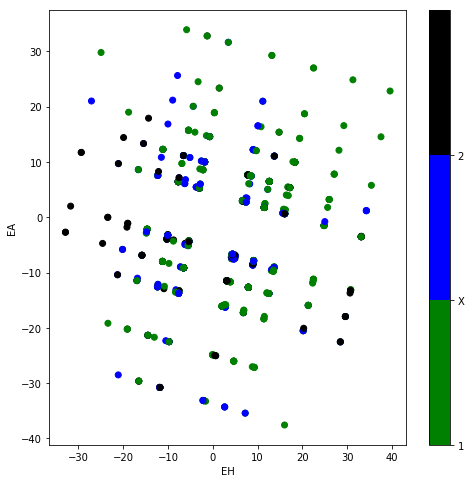

In [41]:
plot_data_labels(fd);

#### NO CV

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75, test_size=0.25, random_state=42)
accs=[]
clfs = []
weights = ['distance','uniform']
max_nei = 5
for w in weights:
    print(w)
    acc = []
    for n in range(1,max_nei):
        print(n)
        clf = KNeighborsClassifier(n_neighbors=n,weights=w)
        clf.fit(X_train, y_train) 
        acc.append(clf.score(X_test, y_test))
    accs.append(acc)

for w, a in enumerate(accs):
    plt.plot(range(1,max_nei), a, label=weights[w])
plt.legend()

#### with cv

In [ ]:
accs=[]
clfs = []
weights = ['distance','uniform']
max_nei = 5
for w in weights:
    print(w)
    acc = []
    for n in range(1,max_nei):
        print(n)
        clf = KNeighborsClassifier(n_neighbors=n,weights=w)
        predicted = cross_val_predict(clf, X, y, cv=5)
        acc.append(metrics.accuracy_score(predicted , y))

    accs.append(acc)

for w, a in enumerate(accs):
    plt.plot(range(1,max_nei), a, label=weights[w])
plt.legend()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75, test_size=0.25, random_state=42)

In [ ]:
weights = ['distance','uniform']

clf = KNeighborsClassifier(n_neighbors=5,weights=weights[0])

In [ ]:
clf.fit(X_train, y_train) 

In [ ]:
y_pred = clf.predict(X_test)

X.shape

pprint.pprint(metrics.accuracy_score(y_pred, y_test))
pprint.pprint(metrics.classification_report(y_pred, y_test))

## GAUSSIAN

In [42]:
fns = [classify]
out = pipeline_func(fd,fns)

   home_team  away_team         EH         EA  result_final
3       1328       2217 -11.205144  -7.983989           2.0
4       4397       3683   6.751962   2.922496           0.0
5        110       4260  18.322870   9.950240           0.0
6       4919       1727  18.322870   9.950240           0.0
7       2644       5306  29.240713  16.581336           0.0
[Classifier]
Accuracy:  0.4824006204187827
('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.84      0.48      0.61     31450\n'
 '        1.0       0.00      0.00      0.00         0\n'
 '        2.0       0.30      0.48      0.37      8523\n'
 '\n'
 'avg / total       0.73      0.48      0.56     39973\n')


/home/kasper/PycharmProjects/venv/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [43]:
fd

,home_team,away_team,EH,EA,result_final
3,1328,2217,-11.205144,-7.983989,2.0
4,4397,3683,6.751962,2.922496,0.0
5,110,4260,18.322870,9.950240,0.0
6,4919,1727,18.322870,9.950240,0.0
7,2644,5306,29.240713,16.581336,0.0
8,837,7516,18.322870,9.950240,0.0
9,5291,4629,18.322870,9.950240,0.0
10,323,2587,-5.335377,-4.418909,2.0
12,7804,3431,39.548440,22.841870,0.0
13,6367,3150,6.751962,2.922496,0.0


## XGBClassifier

In [44]:
clf2 = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1, verbose_eval=True)

In [45]:
clf2 = clf2.fit(X_train, y_train)

In [46]:
predictions2 = clf2.predict(X_test)
pprint.pprint(metrics.classification_report(y_test, predictions2))

('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.50      0.82      0.63     17964\n'
 '        1.0       0.57      0.01      0.01      8224\n'
 '        2.0       0.51      0.39      0.45     13785\n'
 '\n'
 'avg / total       0.52      0.51      0.44     39973\n')


/home/kasper/PycharmProjects/venv/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [18]:
tpot = TPOTClassifier(generations=5, population_size=13, verbosity=2, warm_start=True)
tpot

TPOTClassifier(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed'], 'linkage': ['ward', 'complete', 'average']}, 'sklearn.kernel_approximation.RBFSampler': {'gamma': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ...01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.preprocessing.StandardScaler': {}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        early_stop=None, generations=5, max_eval_time_mins=5,
        max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
        offspring_size=13, periodic_checkpoint_folder=None,
        population_size=13, random_state=None, scoring=None, subsample=1.0,
        verbosity=2, warm_start=True)

In [19]:
clf = tpot.fit(X_train, y_train)



TPOT closed prematurely. Will use the current best pipeline.


RuntimeError: A pipeline has not yet been optimized. Please call fit() first.

In [ ]:
print(clf.score(X_test, y_test))

clf.export('tpot_mnist_pipeline.py')

predictions = clf.predict(X_test)

pprint.pprint(metrics.classification_report(predictions, y_test))

### sources

In [ ]:
#https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python

In [ ]:
# sudo apt-get install build-essentials gfortran gcc